In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc,roc_auc_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,StackingClassifier,RandomForestClassifier
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection 
from sklearn import ensemble
from sklearn import naive_bayes
from time import time
from sklearn import linear_model, tree, model_selection

data = pd.read_csv('train_20D8GL3.csv')             

In [108]:
index_valid=[i for i in range(0,len(data.index)) if 0<data.EDUCATION[i]<5]

In [109]:
validata=data.iloc[index_valid[:],1:] #excluding invalid rows and useless attribute (ID)

In [110]:
validata=validata.reset_index(drop=True)

In [111]:
def optimal_binning_boundary(x: pd.Series, y: pd.Series) -> list:
    '''
        compute boundary of bins using results given by decision trees
    '''
    boundary = []  #boundary of bins to be returned
    
    x = x.values
    y = y.values
    
    clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=6, min_samples_leaf=0.05)

    clf.fit(x.reshape(-1, 1), y)  #train the decision trees
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  #compute the boundary values at the nodes of decision trees
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x.min()
    max_x = x.max() + 0.1  #to include the maximum sample of the attribute for the groupby method
    boundary = [min_x] + boundary + [max_x]

    return boundary

In [112]:
def attribute_woe_iv(x: pd.Series, y: pd.Series) -> pd.DataFrame:
    '''
        return a DataFrame showing the WOE and IV values of an attribute     #Weight of Evidence(WOE) & Information Value(IV)
    '''
    boundary = optimal_binning_boundary(x, y)        #boundaries as an internal input
    df = pd.concat([x, y], axis=1)                        
    df.columns = ['x', 'y']                               
    df['bins'] = pd.cut(x=x, bins=boundary, right=False)  #get the sub-interval where x locates
    
    grouped = df.groupby('bins')['y']                     #count the number of default/survival and their totals of each bin
    result_df = grouped.agg([('good',  lambda y: (y == 0).sum()), 
                             ('bad',   lambda y: (y == 1).sum()),
                             ('total', 'count')])

    result_df['good_pct'] = result_df['good'] / result_df['good'].sum()       #default ratio
    result_df['bad_pct'] = result_df['bad'] / result_df['bad'].sum()          #survival ratio
    result_df['total_pct'] = result_df['total'] / result_df['total'].sum()    #total ratio

    result_df['bad_rate'] = result_df['bad'] / result_df['total']             #bad rate
    
    result_df['woe'] = np.log(result_df['good_pct'] / result_df['bad_pct'])              # WOE
    result_df['iv'] = (result_df['good_pct'] - result_df['bad_pct']) * result_df['woe']  # IV
    
    return result_df

In [113]:
attributes_discretized=validata.iloc[:,[0]+list(range(11,23))]

In [114]:
for i in attributes_discretized.columns:
    result_df=attribute_woe_iv(x=attributes_discretized[i],y=validata.default_payment_next_month)
    if (result_df.woe.is_monotonic and result_df.woe.is_unique)==True: #WOE must be monotonically related to the variate
        print(i,sum(result_df.iv))

LIMIT_BAL 0.19582867876291427
PAY_AMT3 0.1417805874922513
PAY_AMT4 0.11842355786796864
PAY_AMT5 0.10893921018538047


In [115]:
def discretizer(a, b):
        for i in range(0,len(b)):
            if b[i]<=a<b[i+1]:
                return i
            else:
                pass

In [116]:
df_X=pd.concat([validata.LIMIT_BAL, validata.PAY_AMT3, validata.PAY_AMT4, validata.PAY_AMT5], axis=1)
df_X.head(3)

,LIMIT_BAL,PAY_AMT3,PAY_AMT4,PAY_AMT5
0,360000,3446,8870,2020
1,240000,2240,0,2267
2,320000,2000,3000,3000


In [117]:
for i in range(0,len(df_X.columns)):
    b=optimal_binning_boundary(x=df_X.iloc[:,i], y=validata.default_payment_next_month)
    df_X.iloc[:,i]=pd.DataFrame([discretizer(df_X.iloc[:,i][j],b) for j in range(0,len(validata.default_payment_next_month))])

In [118]:
df_X=pd.concat([df_X, validata.iloc[:,1:5], validata.iloc[:,5:11]], axis=1)

In [119]:
df_X.SEX=df_X.SEX-1
#df_X

In [120]:
onehotencoder = OneHotEncoder()  

In [121]:
marriage=onehotencoder.fit_transform(df_X.MARRIAGE.values.reshape(-1,1)).toarray()  #1 row
#marriage

In [122]:
dfOneHot=pd.DataFrame(marriage, columns = ['WIDOWED','MARRIED','SINGLE','DIVORCED']) 
#dfOneHot

In [123]:
df_X=df_X.drop(['MARRIAGE'], axis=1)

In [124]:
df_X=pd.concat([df_X, dfOneHot], axis=1)

In [125]:
df_X=df_X.drop(['WIDOWED'], axis=1) #avoid perfect multicollinearity
#df_X

In [126]:
max_abs_scaler=MaxAbsScaler()

In [128]:
df_X_maxabs= max_abs_scaler.fit_transform(df_X) #normalisation

In [129]:
df_X_maxabs=pd.DataFrame(df_X_maxabs,columns = df_X.columns)

In [130]:
df_X=df_X_maxabs
df_X.columns
df_X.shape

(20756, 16)

In [131]:
df_Y=validata.default_payment_next_month

[0.09189265 0.06249188 0.06269137 0.07527733 0.03325801 0.05696399
 0.24325345 0.17901101 0.0359615  0.03808784 0.03263604 0.03307632
 0.02812408 0.01194024 0.01243873 0.00289554]


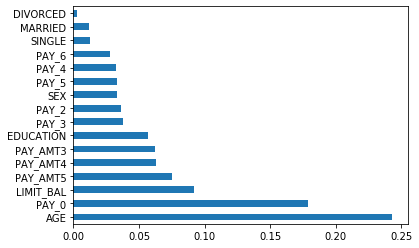

In [132]:
#feature selection: method 1 - Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = tree.ExtraTreeClassifier()
model.fit(df_X,df_Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=df_X.columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

In [155]:
df_X_select3 = df_X[['AGE','PAY_0','LIMIT_BAL']]
df_X_select5 = df_X[['AGE','PAY_0','LIMIT_BAL','PAY_AMT5','PAY_AMT4']]

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df_X_select5, df_Y, test_size=0.3, random_state=0)

In [135]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn import metrics

def train_predict(learner,X_train, y_train, X_test, y_test): 

    results = {}
    results["1_model"] = learner.__class__.__name__
    
    # training
    start = time() 
    learner = learner.fit(X_train,y_train)
    end = time() 
    # training time
    results['2_train_time'] = end-start
    
    # predict
    start = time() 
    predictions_test = learner.predict(X_test)
    end = time() 
    # predicting time
    results['3_pred_time'] = end-start
            
      
    # accuracy on test set
    results['4_acc_test'] = accuracy_score(y_test,predictions_test)
    # F score on test set
    results['5_f_test'] = f1_score(y_test,predictions_test)
    results['6_f2_test'] = metrics.fbeta_score(y_test, predictions_test, beta = 2)
    results['7_recall'] = metrics.recall_score(y_test, predictions_test)
    
    return results

In [156]:
clfs = {}

# GaussianNB
from sklearn.naive_bayes import GaussianNB
clfs["nb"] = GaussianNB()

# random forest
from sklearn.tree import DecisionTreeClassifier
clfs["dtc"] = DecisionTreeClassifier()

# KNeighbors
from sklearn.neighbors import KNeighborsClassifier
clfs["knc"] = KNeighborsClassifier()

# SVC
from sklearn.svm import SVC
clfs["svc"] = SVC()

# Logistic regression
from sklearn.linear_model import LogisticRegression
clfs['lr'] = LogisticRegression()

# random forest
from sklearn.ensemble import RandomForestClassifier
clfs["rfc"] = RandomForestClassifier()

# AdaBoosting
from sklearn.ensemble import AdaBoostClassifier
clfs["adc"] = AdaBoostClassifier()

# gbdt
from sklearn.ensemble import GradientBoostingClassifier
clfs["gbdt"] = GradientBoostingClassifier()

In [137]:
totaldata = pd.DataFrame(columns=['1_model', 
                                  '2_train_time', 
                                  '3_pred_time', 
                                  '4_acc_test', 
                                  '5_f_test',
                                  '6_f2_test',
                                  '7_recall'])

for clf in clfs:
    print(clf)
    # print(clfs[clf])
    temp = train_predict(clfs[clf],X_train, y_train, X_test, y_test)
    rdata = pd.DataFrame(pd.Series(temp)).T
    totaldata=pd.concat([totaldata,rdata])

nb
dtc
knc
svc
lr
rfc
adc
gbdt


In [138]:
totaldata.reset_index(drop = True)

,1_model,2_train_time,3_pred_time,4_acc_test,5_f_test,6_f2_test,7_recall
0,GaussianNB,0.00498414,0.00503182,0.814678,0.439806,0.360784,0.322191
1,DecisionTreeClassifier,0.0119593,0.0029881,0.799101,0.382832,0.310649,0.27596
2,KNeighborsClassifier,0.0498357,0.181396,0.780633,0.408146,0.360864,0.334993
3,SVC,3.74748,0.516276,0.813393,0.432063,0.35281,0.314367
4,LogisticRegression,0.0667734,0.00199676,0.807451,0.370604,0.288257,0.251067
5,RandomForestClassifier,0.540199,0.101669,0.801028,0.422916,0.356638,0.322902
6,AdaBoostClassifier,0.235213,0.0328865,0.814678,0.445725,0.368254,0.330014
7,GradientBoostingClassifier,0.503837,0.0174811,0.813875,0.446778,0.370664,0.332859


In [139]:
totaldata.sort_values(by="7_recall",ascending=False).reset_index(drop = True)

,1_model,2_train_time,3_pred_time,4_acc_test,5_f_test,6_f2_test,7_recall
0,KNeighborsClassifier,0.0498357,0.181396,0.780633,0.408146,0.360864,0.334993
1,GradientBoostingClassifier,0.503837,0.0174811,0.813875,0.446778,0.370664,0.332859
2,AdaBoostClassifier,0.235213,0.0328865,0.814678,0.445725,0.368254,0.330014
3,RandomForestClassifier,0.540199,0.101669,0.801028,0.422916,0.356638,0.322902
4,GaussianNB,0.00498414,0.00503182,0.814678,0.439806,0.360784,0.322191
5,SVC,3.74748,0.516276,0.813393,0.432063,0.35281,0.314367
6,DecisionTreeClassifier,0.0119593,0.0029881,0.799101,0.382832,0.310649,0.27596
7,LogisticRegression,0.0667734,0.00199676,0.807451,0.370604,0.288257,0.251067


In [36]:
#KNN
recall_scorer = metrics.make_scorer(metrics.recall_score) #objective function   
knn = KNeighborsClassifier()    
param_test = {'n_neighbors': range(1,15), 'weights':['uniform','distance'], 'p': range(1,10)}
knn_grid = model_selection.GridSearchCV(knn, param_test,scoring=recall_scorer, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2020), n_jobs=-1)
knn_grid.fit(X_train,y_train)
knn_grid.best_params_, knn_grid.best_score_  

({'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}, 0.38948233755744865)

In [37]:
#Random Forest  
rf = ensemble.RandomForestClassifier()  
param_test = { 'n_estimators':[50,100,200,500],'max_depth':range(3,14,4), 'min_samples_split':range(50,201,50)}
rf_grid = model_selection.GridSearchCV(rf, param_test,scoring=recall_scorer, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2020), n_jobs=-1)
rf_grid.fit(X_train,y_train)
rf_grid.best_params_,rf_grid.best_score_ 

({'max_depth': 11, 'min_samples_split': 50, 'n_estimators': 500},
 0.3541055323731323)

In [38]:
param_test = {'min_samples_split':[30,50,80], 'min_samples_leaf':[2,5,7,10], 'max_features':[1,2,3]}
rf_grid2 = model_selection.GridSearchCV(ensemble.RandomForestClassifier(n_estimators = 500,max_depth = 11, min_samples_split = 50), param_test,scoring=recall_scorer, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2020), n_jobs=-1)
rf_grid2.fit(X_train,y_train)
rf_grid2.best_params_,rf_grid.best_score_ 

({'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 30},
 0.3541055323731323)

In [59]:
param_test = {'class_weight': [{0:1,1:10},{0:1,1:15}]}
rf_grid2 = model_selection.GridSearchCV(RandomForestClassifier(n_estimators = 500,max_depth = 11, max_features = 3, min_samples_leaf = 10, min_samples_split = 30), param_test,scoring=recall_scorer, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2020), n_jobs=-1)
rf_grid2.fit(X_train,y_train)
rf_grid2.best_params_,rf_grid.best_score_ 

({'class_weight': {0: 1, 1: 15}}, 0.3541055323731323)

In [40]:
#gradient boosting hyperparameter tuning
param_test1 = {'n_estimators':[50,100,200,500,100]}
gb_gsearch1 =  model_selection.GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test1, scoring=recall_scorer, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2020), n_jobs=-1)
gb_gsearch1.fit(X_train,y_train)
gb_gsearch1.best_params_, gb_gsearch1.best_score_

({'n_estimators': 100}, 0.36465107782243333)

In [41]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gb_gsearch2 =  model_selection.GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring=recall_scorer, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2020), n_jobs=-1)
gb_gsearch2.fit(X_train,y_train)
gb_gsearch2.best_params_, gb_gsearch2.best_score_

({'max_depth': 13, 'min_samples_split': 200}, 0.363097321308386)

In [42]:
param_test3 = {'min_samples_leaf':[30,60,90,120,160,260], 'subsample':[0.9, 5, 8, 20]}
gb_gsearch3 = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=13,min_samples_split = 200, max_features='sqrt', random_state=10), 
param_grid = param_test3, scoring=recall_scorer, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2020), n_jobs=-1)
gb_gsearch3.fit(X_train,y_train)
gb_gsearch3.best_params_, gb_gsearch3.best_score_

({'min_samples_leaf': 120, 'subsample': 0.9}, 0.3643414802992135)

In [140]:
rf_tune = RandomForestClassifier(n_estimators = 500,max_depth = 11, max_features = 3, min_samples_leaf = 10, min_samples_split = 30, class_weight = {0:1,1:15})
knn_tune = KNeighborsClassifier(n_neighbors = 1, p = 2, weights = 'uniform')
gb_tune = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=13,min_samples_split = 200,min_samples_leaf =120,  max_features='sqrt', subsample=0.9, random_state=10)
gnb = naive_bayes.GaussianNB()

In [148]:
rf_tune.fit(X_train, y_train)
y_pred_rf = rf_tune.predict(X_test)
print("Random Forest")
print("Accuuracy:", metrics.accuracy_score(y_test, y_pred_rf))
print('precision:', metrics.precision_score(y_test, y_pred_rf))
print('recall:', metrics.recall_score(y_test, y_pred_rf))
print("f1 score:", metrics.f1_score(y_test, y_pred_rf))
print("f2 score:", metrics.fbeta_score(y_test, y_pred_rf, beta = 2))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_rf))

Random Forest
Accuuracy: 0.33178095391039025
precision: 0.24400669020628135
recall: 0.933854907539118
f1 score: 0.38691616325327827
f2 score: 0.5965470240799637
Confusion Matrix:
[[ 753 4068]
 [  93 1313]]


In [149]:
knn_tune.fit(X_train, y_train)
y_pred_knn = knn_tune.predict(X_test)
print("KNN")
print("Accuuracy:", metrics.accuracy_score(y_test, y_pred_knn))
print('precision:', metrics.precision_score(y_test, y_pred_knn))
print('recall:', metrics.recall_score(y_test, y_pred_knn))
print("f1 score:", metrics.f1_score(y_test, y_pred_knn))
print("f2 score:", metrics.fbeta_score(y_test, y_pred_knn, beta = 2))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_knn))

KNN
Accuuracy: 0.7191263850971575
precision: 0.37305699481865284
recall: 0.3584637268847795
f1 score: 0.3656147986942329
f2 score: 0.3612903225806452
Confusion Matrix:
[[3974  847]
 [ 902  504]]


In [150]:
gb_tune.fit(X_train, y_train)
y_pred_gb = gb_tune.predict(X_test)
print("GradientBoosting")
print("Accuuracy:", metrics.accuracy_score(y_test, y_pred_gb))
print('precision:', metrics.precision_score(y_test, y_pred_gb))
print('recall:', metrics.recall_score(y_test, y_pred_gb))
print("f1 score:", metrics.f1_score(y_test, y_pred_gb))
print("f2 score:", metrics.fbeta_score(y_test, y_pred_gb, beta = 2))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_gb))

GradientBoosting
Accuuracy: 0.8103420587762967
precision: 0.6577840112201964
recall: 0.3335704125177809
f1 score: 0.44266163284568194
f2 score: 0.3700489190468676
Confusion Matrix:
[[4577  244]
 [ 937  469]]


In [151]:
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print("GaussianNB")
print("Accuuracy:", metrics.accuracy_score(y_test, y_pred_gnb))
print('precision:', metrics.precision_score(y_test, y_pred_gnb))
print('recall:', metrics.recall_score(y_test, y_pred_gnb))
print("f1 score:", metrics.f1_score(y_test, y_pred_gnb))
print("f2 score:", metrics.fbeta_score(y_test, y_pred_gnb, beta = 2))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_gnb))

GaussianNB
Accuuracy: 0.8146780150955516
precision: 0.6926605504587156
recall: 0.32219061166429586
f1 score: 0.43980582524271844
f2 score: 0.3607836890729531
Confusion Matrix:
[[4620  201]
 [ 953  453]]


In [152]:
#voting & stacking
#estimator
es = (('rf_tune',RandomForestClassifier(n_estimators = 500,max_depth = 11, max_features = 3, min_samples_leaf = 10, min_samples_split = 30 )),
      ('knn_tune',KNeighborsClassifier(n_neighbors = 1, p = 2, weights = 'uniform')), 
      ('gb_tune', GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=13,min_samples_split = 200,min_samples_leaf =120,  max_features='sqrt', subsample=0.9, random_state=10)), 
      ('gnb', naive_bayes.GaussianNB()))

vot = VotingClassifier(estimators = es, voting='soft')
vot.fit(X_train,y_train)
y_pred_vot = vot.predict(X_test)

print("VotingClassifier:")
print("Accuuracy:", accuracy_score(y_test, y_pred_vot))
print('precision:', metrics.precision_score(y_test, y_pred_vot))
print('recall:', metrics.recall_score(y_test, y_pred_vot))
print("f1 score:", metrics.f1_score(y_test, y_pred_vot))
print("f2 score:", metrics.fbeta_score(y_test, y_pred_vot, beta = 2))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_vot))

stack = StackingClassifier(estimators = es, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2020), n_jobs=-1)
stack.fit(X_train,y_train)
y_pred_stack = stack.predict(X_test)

print("StackingClassifier:")      
print("Accuuracy:", accuracy_score(y_test, y_pred_stack))
print('precision:', metrics.precision_score(y_test, y_pred_stack))
print('recall:', metrics.recall_score(y_test, y_pred_stack))
print("f1 score:", metrics.f1_score(y_test, y_pred_stack))
print("f2 score:", metrics.fbeta_score(y_test, y_pred_stack, beta = 2))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_stack))

VotingClassifier:
Accuuracy: 0.8047213746587442
precision: 0.6353276353276354
recall: 0.31721194879089615
f1 score: 0.42314990512333966
f2 score: 0.35251343661081247
Confusion Matrix:
[[4565  256]
 [ 960  446]]
StackingClassifier:
Accuuracy: 0.8140356511964028
precision: 0.6802325581395349
recall: 0.3328591749644381
f1 score: 0.4469914040114613
f2 score: 0.37072243346007605
Confusion Matrix:
[[4601  220]
 [ 938  468]]


In [153]:
y_prob_gnb = gnb.predict_proba(X_test)              
fpr_gnb, tpr_gnb, _ = metrics.roc_curve(y_test, y_prob_gnb[:,1])      
auc_roc_gnb = metrics.auc(fpr_gnb, tpr_gnb)

y_prob_knn_tune = knn_tune.predict_proba(X_test)
fpr_knn_tune, tpr_knn_tune, _ = metrics.roc_curve(y_test, y_prob_knn_tune[:,1])
auc_roc_knn_tune = metrics.auc(fpr_knn_tune, tpr_knn_tune)

y_prob_gb_tune = gb_tune.predict_proba(X_test)
fpr_gb_tune, tpr_gb_tune, _ = metrics.roc_curve(y_test, y_prob_gb_tune[:,1])
auc_roc_gb_tune = metrics.auc(fpr_gb_tune, tpr_gb_tune)

y_prob_rf_tune = rf_tune.predict_proba(X_test)
fpr_rf_tune, tpr_rf_tune, _ = metrics.roc_curve(y_test, y_prob_rf_tune[:,1])
auc_roc_rf_tune = metrics.auc(fpr_rf_tune, tpr_rf_tune)

y_prob_vot = vot.predict_proba(X_test)
fpr_vot, tpr_vot, _ = metrics.roc_curve(y_test, y_prob_vot[:,1])
auc_roc_vot = metrics.auc(fpr_vot, tpr_vot)

y_prob_stack = stack.predict_proba(X_test)
fpr_stack, tpr_stack, _ = metrics.roc_curve(y_test, y_prob_stack[:,1])
auc_roc_stack = metrics.auc(fpr_stack, tpr_stack)

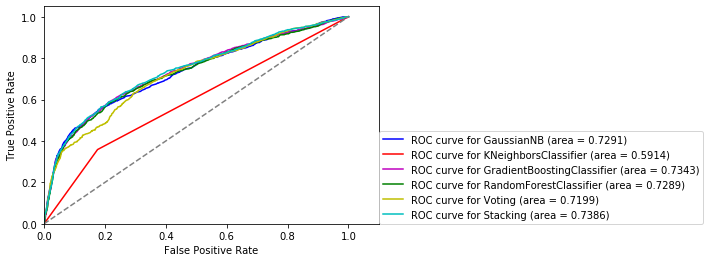

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline          


plt.plot(fpr_gnb, tpr_gnb, c = 'b', label = 'ROC curve for GaussianNB (area = %0.4f)' % auc_roc_gnb)
plt.plot(fpr_knn_tune, tpr_knn_tune, c = 'r', label = 'ROC curve for KNeighborsClassifier (area = %0.4f)' % auc_roc_knn_tune)
plt.plot(fpr_gb_tune, tpr_gb_tune, c = 'm', label = 'ROC curve for GradientBoostingClassifier (area = %0.4f)' % auc_roc_gb_tune)
plt.plot(fpr_rf_tune, tpr_rf_tune, c = 'g', label = 'ROC curve for RandomForestClassifier (area = %0.4f)' % auc_roc_rf_tune)
plt.plot(fpr_vot, tpr_vot, c = 'y', label = 'ROC curve for Voting (area = %0.4f)' % auc_roc_vot)
plt.plot(fpr_stack, tpr_stack, c = 'c', label = 'ROC curve for Stacking (area = %0.4f)' % auc_roc_stack)


plt.plot([0, 1], [0, 1], c = 'gray', ls = '--')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')          
plt.legend(loc=[1, 0])
plt.show()